In [1]:
import numpy as np
import cma

## Define deviated environments

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state):
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

### Visualize gym helpers

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import time
import imageio
%matplotlib inline


# Define visual experiment
def init_fig(env):
    plt.figure()
    plt.title(f"{env.spec.id} | Episode: 0 | Step: 0 | Reward: 0.0")
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, episode, step, total_reward, done):
    title = plt.title(f"{env.spec.id}\nEp.: {episode} | Step: {step} | Reward: {total_reward} | Done: {done}")
    if done:
        plt.setp(title, color='r')
    else:
        plt.setp(title, color='k')
    img.set_data(env.render(mode='rgb_array'))
    fig = plt.gcf()
    display.display(fig)
    display.clear_output(wait=True)
    
    return np.asarray(fig.canvas.buffer_rgba())

def visual_experiment(env, next_action, max_episode_steps=100, reset_to=None, visualize_in_notebook=True,
                      sleep=0.01, save_gif=None, model_reset=None):
    if reset_to is not None:
        obs = env.reset_to(reset_to)
    else:
        obs = env.reset()
    
    if model_reset is not None:
        model_reset()
    
    if save_gif is not None:
        gif = []
    else:
        gif = None

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)

    total_reward = 0.0
    for step in range(1, max_episode_steps+1):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward

        if visualize_in_notebook:
            fig_data = update_fig(img, env, 1, step, total_reward, done)
            if save_gif is not None:
                gif.append(fig_data)
        else:
            env.render()

        if sleep > 0.0:
            time.sleep(sleep)
    
    if save_gif is not None:
        imageio.mimsave(save_gif, [data for data in gif], fps=10)

## Helper functions

In [4]:
def scale_x(x, bounds):
    """Scale the input numbers in [0, 1] to the range of each variable"""
    return bounds[:, 0] + x * (bounds[:, 1] - bounds[:, 0])

def normalize_x(x_scaled, bounds):
    return (x_scaled - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

In [5]:
def visualize_deviated_env(x, reset_to, save_gif=None):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    visual_experiment(env, next_action, model_reset=model_reset, max_episode_steps=max_episode_steps,
                      reset_to=reset_to, save_gif=save_gif)
    env.close()

## Define PID Agent

In [6]:
# credits to: https://gist.github.com/HenryJia/23db12d61546054aa43f8dc587d9dc2c
class PID:
    def __init__(self):
        self.desired_state = np.array([0, 0, 0, 0])
        self.desired_mask = np.array([0, 0, 1, 0])
        self.P, self.I, self.D = 0.1, 0.01, 0.5
        
        self.reset()
    
    def reset(self):
        self.integral = 0
        self.derivative = 0
        self.prev_error = 0
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def next_action(self, obs):
        error = obs - self.desired_state

        self.integral += error
        self.derivative = error - self.prev_error
        self.prev_error = error

        pid = np.dot(self.P * error + self.I * self.integral + self.D * self.derivative, self.desired_mask)
        action = self.sigmoid(pid)
        return np.round(action).astype(np.int32)

## Define STL robustness estimation functions

In [7]:
# Compute robustness value of the STL formula:
#   G ( pos > -2.4 & pos < 2.4 & angle > -12 degree & angle < 12 degree )
import signal_tl as stl

pos = stl.Predicate('pos')
angle = stl.Predicate('angle')

pos_threshold = 2.4
angle_threshold = 12 * 2 * np.pi / 360

phi = stl.Always(
    (pos > -pos_threshold) & (pos < pos_threshold) &\
    (angle > -angle_threshold) & (angle < angle_threshold)
)

def compute_STL_robustness(records):
    if records.ndim == 2:
        records = np.array([records])
    
    time_index = np.arange(records.shape[1])
    robs = []
    for i in range(len(records)):
        trace = {
            "pos": stl.Signal(records[i, :, 0], time_index),
            "angle": stl.Signal(records[i, :, 2], time_index)
        }
        rob = stl.compute_robustness(phi, trace)
        robs.append(rob.at(0))
    return np.array(robs)

### Estimate robustness by random sampling

In [8]:
def random_sample(env, next_action, max_episode_steps=100, max_episodes=3, model_reset=None):
    space = env.observation_space
    # episode_rewards = []
    episode_obs_records = []

    for episode in range(max_episodes):
        # reset env
        obs = env.reset()
        
        if model_reset is not None:
            model_reset()
        
        # total_reward = 0.0
        obs_records = [obs]
        out_space = False
        
        for step in range(max_episode_steps):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            
            # total_reward += reward
            
            # if the observation is out of the space, clip it and then terminate the episode
            if np.sum(obs < space.low) > 0 or np.sum(obs > space.high) > 0:
                obs = np.clip(obs, space.low, space.high)
                out_space = True
            obs_records.append(obs)
            
            if out_space:
                obs_records = np.append(obs_records, np.full((max_episode_steps-step-1, len(obs)), obs), axis=0)
                break

        # episode_rewards.append(total_reward)
        episode_obs_records.append(obs_records)

    # return np.array(episode_rewards), np.array(episode_obs_records)
    return np.array(episode_obs_records)

In [9]:
# define constraints where input x is in the original domain
def estimate_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)

    # fix the seed so that we can fix the initial states for sampling
    records = random_sample(
        env,
        next_action,
        max_episode_steps=max_episode_steps,
        max_episodes=max_episodes,
        model_reset=model_reset
    )

    env.close()
    return compute_STL_robustness(records).min()

# wrapped constraints function where input x is in [0, 1] and should be scaled to the original domain
def scaled_estimate_min_STL_robustness(x):
    return estimate_min_STL_robustness(scale_x(x, env_bounds))

### Estimate min robustness by using CMA-ES by varying the initial state

In [10]:
# define the range of the initial set
init_range = np.repeat([[-0.05, 0.05]], 4, axis=0)

In [11]:
def episode_by_init(env, x, next_action, max_episode_steps, model_reset=None):
    space = env.observation_space
    obs = env.reset_to(x)
    obs_records = [obs]
    out_space = False
    
    if model_reset is not None:
        model_reset()
    
    for step in range(max_episode_steps):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)

        # if the observation is out of the space, clip it and then terminate the episode
        if np.sum(obs < space.low) > 0 or np.sum(obs > space.high) > 0:
            obs = np.clip(obs, space.low, space.high)
            out_space = True
        obs_records.append(obs)

        if out_space:
            obs_records = np.append(obs_records, np.full((max_episode_steps-step-1, len(obs)), obs), axis=0)
            break
    
    return np.array(obs_records)


def cma_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    def objective(y):
        record = episode_by_init(env, y, next_action, model_reset=model_reset, max_episode_steps=max_episode_steps)
        return compute_STL_robustness(record)[0]
    
    y0 = np.zeros(4) # TODO: https://lig-kobe-grenoble.imag.fr/wp-content/uploads/2018/03/05.-Session-4-presentation-1-Thao-Dang.pdf
    sigma0 = 0.2
    min_x, es = cma.fmin2(
        lambda y: objective(scale_x(y, init_range)),
        y0,
        sigma0,
        {'bounds': [0.0, 1.0], 'maxfeval': max_episodes, 'ftarget': min_STL_robustness_target, 'verbose': -9, 'seed': seed}
    )
    
    env.close()
    
    return es.result.fbest, scale_x(min_x, init_range)

def scaled_cma_min_STL_robustness(x):
    fbest, _ = cma_min_STL_robustness(scale_x(x, env_bounds))
    return fbest

### Problem configurations

In [42]:
# define variables and their bounds
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]
env_bounds = np.array([
    masscart,
    force_mag
])

# define objective function
x_original = [
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
]

In [43]:
seed = 19279
model = PID()
next_action = lambda obs: model.next_action(obs)
model_reset = lambda : model.reset()
max_episode_steps = 200
max_episodes = 100
min_STL_robustness_target = 0.0

### Compare two sampling methods

In [14]:
# CMA is better when the agent is deterministic
# for x in np.random.rand(3, 2):
#     est1 = scaled_estimate_min_STL_robustness(x)
#     est2 = scaled_cma_min_STL_robustness(x)
#     if est1 < est2:
#         print(est1, est2, "Random Sample")
#     else:
#         print(est1, est2, "CMA")

### The agent should be safe under the original environment by falsification

In [15]:
fbest, _ = cma_min_STL_robustness(x_original)
fbest > 0.0

True

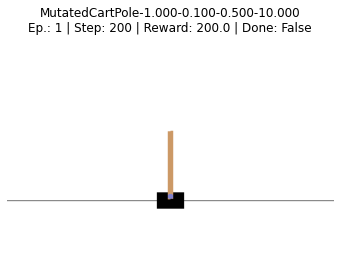

In [16]:
visualize_deviated_env(x_original, [0.0, 0.0, 0.0, 0.0], "gifs/default_env.gif")

In [17]:
# l-2 norm distance, the input x is in the original domain
def deviation_dist(x):
    """The variables of the objective function are normalized to [0, 1)"""
    return np.sqrt(np.sum((x - x_original) ** 2))

# wrapped objective function where input x is in [0, 1] and should be scaled to the original domain
def scaled_deviation_dist(x):
    return deviation_dist(scale_x(x, env_bounds))

### CMA for minimizing the STL robustness value given the bounded deviation

In [18]:
# small deviation to have maximize the change in robustness value
# in other words, robustness is: |I' - I| < \Delta => |O' - O| < \epsilon, to falsify the robustness, find an input I''
#   s.t. |I'' - I| < \Delta /\ |O'' - O| > \epsilon

In [19]:
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

_, es1 = cma.fmin2(
    scaled_cma_min_STL_robustness,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'ftarget': min_STL_robustness_target, 'tolstagnation': 0,
     'tolx': 1e-5, 'timeout': 30 * 60, 'verbose': -9},
)

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [20]:
es1.result

CMAEvolutionStrategyResult(xbest=array([0.0303523 , 0.91999636]), fbest=-0.058836555348677905, evals_best=11, evaluations=13, iterations=2, xfavorite=array([0.08193406, 0.99877468]), stds=array([0.40880147, 0.5134856 ]), stop={'ftarget': 0.0})

In [21]:
x = es1.result.xbest
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [ 0.15766936 18.47993075]
Deviation distance: 8.521663365461842
Counterexample initial state: [-0.03855038 -0.03330135 -0.03405994 -0.04841884]
Counterexample robustness value: -0.058836555348677905


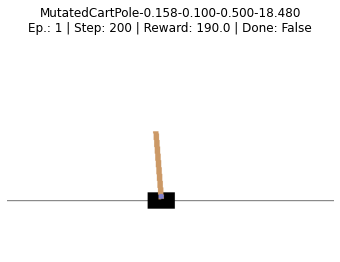

In [22]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs/counterexample.gif")

### CMA-ES for minimizing the deviation s.t. the STL is violated (robustness value <= 0)

In [44]:
# set initial variable values to the default value
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

cfun2 = cma.ConstrainedFitnessAL(scaled_deviation_dist, lambda x: [scaled_cma_min_STL_robustness(x)], find_feasible_first=True)
x, es2 = cma.fmin2(
    cfun2,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolx': 1e-5, 'timeout': 30 * 60, 'verbose': -9},
    callback=cfun2.update
)

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.9259751675171664, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))
/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.3669757180681066, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))
/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.43685461994838015, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))
/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.2169962237354967, [0.], [0.]
  _warnings.war

In [45]:
es2.result

CMAEvolutionStrategyResult(xbest=array([0.04989686, 0.61241545]), fbest=0.0026024571140523954, evals_best=8, evaluations=751, iterations=125, xfavorite=array([0.48403154, 0.47378492]), stds=array([5.51149238e-05, 5.26945710e-05]), stop={'tolflatfitness': 1})

In [46]:
# x = es2.result.xbest
# print("Counterexample deviation:", scale_x(x, env_bounds))
# print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
# robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
# print("Counterexample initial state:", x_init)
# print("Counterexample robustness value:", robustness)

In [47]:
# x = es2.result.xfavorite
# print("Counterexample deviation:", scale_x(x, env_bounds))
# print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
# robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
# print("Counterexample initial state:", x_init)
# print("Counterexample robustness value:", robustness)

In [48]:
# plt.rc('font', size=14) 

# es2.plot()

# fig = plt.gcf()
# fig.set_figwidth(18)
# fig.set_figheight(18)

In [49]:
cfun2.best_feas.info

{'x': array([0.00476747, 0.63745434]),
 'f': 3.2366701170538668,
 'g': [-0.0421727655995324],
 'f_al': 3.2366701170538668,
 'g_al': [0.0],
 'count': 15}

In [50]:
x = cfun2.best_feas.info['x']
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [ 0.1090582  13.11163239]
Deviation distance: 3.2366701170538668
Counterexample initial state: [-0.04436436 -0.04229198 -0.04962916 -0.03525   ]
Counterexample robustness value: -0.0421727655995324


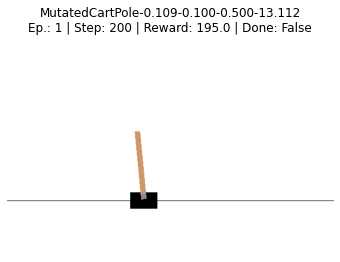

In [51]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs/min_dev_counterexample.gif")

In [52]:
# c = es.countiter
# x = cfun.find_feasible(es)
# print("find_feasible took {} iterations".format(es.countiter - c))
# print("Solution:", scale_x(x, env_bounds))
# print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

### CMA for finding the maximum deviation s.t. the agent is safe

In [32]:
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

cfun3 = cma.ConstrainedFitnessAL(
    lambda x: -scaled_deviation_dist(x), # maximize distance
    lambda x: [-scaled_cma_min_STL_robustness(x)], # robustness >= 0
#     find_feasible_first=True # assume the initial is already feasible
)
x, es3 = cma.fmin2(
    cfun3,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolx': 1e-5, 'timeout': 30 * 60, 'verbose': -9},
    callback=cfun3.update
)

In [33]:
es3.result

CMAEvolutionStrategyResult(xbest=array([0.12252961, 0.00031639]), fbest=-10.174871837195877, evals_best=49, evaluations=1291, iterations=215, xfavorite=array([3.73488336e-04, 4.94757756e-09]), stds=array([0.00013371, 0.00011288]), stop={'timeout': 1800})

In [34]:
# the original x-value may be meaningless
# x = es3.result.xbest
# print("Counterexample deviation:", scale_x(x, env_bounds))
# print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
# robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
# print("Counterexample initial state:", x_init)
# print("Counterexample robustness value:", robustness)

In [35]:
# x = es3.result.xfavorite
# print("Counterexample deviation:", scale_x(x, env_bounds))
# print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
# robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
# print("Counterexample initial state:", x_init)
# print("Counterexample robustness value:", robustness)

In [36]:
x = cfun3.best_feas.info['x']
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [0.10070963 1.00000009]
Deviation distance: 9.044817382423489
Counterexample initial state: [-0.03522084 -0.04885058 -0.04999759 -0.04998998]
Counterexample robustness value: 0.15844212262149307


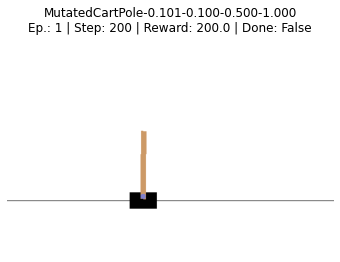

In [37]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs/max_safe_deviation.gif")

### Plot the shape of the optimization space using grid

In [38]:
n_mass, n_force = (50, 50)

In [39]:
masses = np.linspace(masscart[0], masscart[1], n_mass)
forces = np.linspace(force_mag[0], force_mag[1], n_force)
masses, forces = np.meshgrid(masses, forces, indexing='ij')

In [40]:
min_STL_robustness_target = -np.inf
grid_data = np.zeros((n_mass, n_force))

for i in range(n_mass):
    for j in range(n_force):
        # treat xv[i,j], yv[i,j]
        m, f = masses[i, j], forces[i, j]
        robustness, _ = cma_min_STL_robustness([m, f])
        grid_data[i, j] = robustness

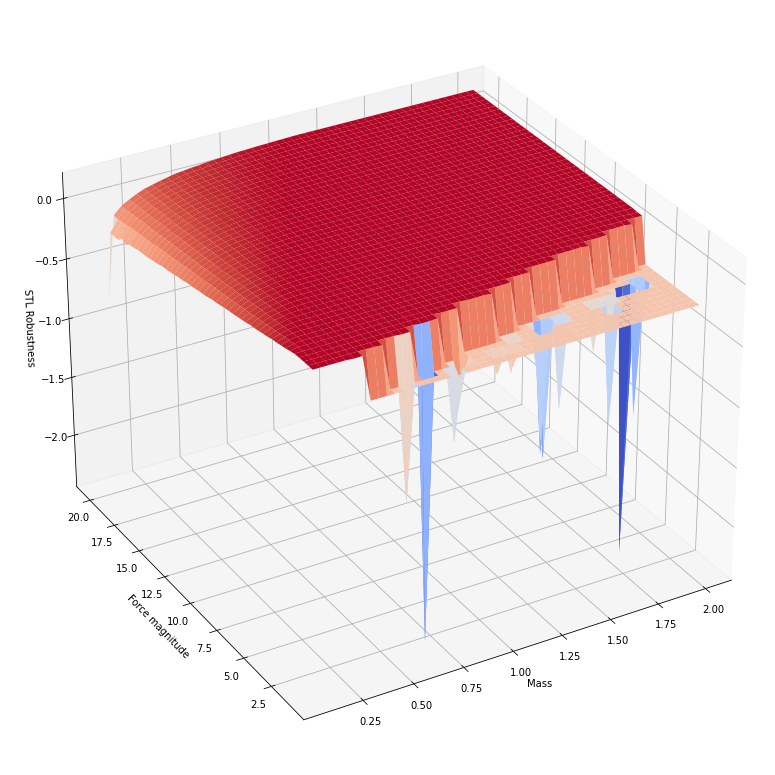

In [41]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 14))
ax.plot_surface(masses, forces, grid_data, cmap=cm.coolwarm)
ax.set_xlabel('Mass')
ax.set_ylabel('Force magnitude')
ax.set_zlabel('STL Robustness')

ax.view_init(30, -120)
plt.savefig('gifs/robustness-landscape.png')
plt.show()

### Plot the falsification space of a given environment by varying the initial state

In [ ]:
def plot_robustness_space_of_init_state(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    num_grid = 10
    
    
    def objective(y):
        record = episode_by_init(env, y, next_action, model_reset=model_reset, max_episode_steps=max_episode_steps)
        return compute_STL_robustness(record)[0]
    
    y0 = np.zeros(4) # TODO: https://lig-kobe-grenoble.imag.fr/wp-content/uploads/2018/03/05.-Session-4-presentation-1-Thao-Dang.pdf
    sigma0 = 0.2
    min_x, es = cma.fmin2(
        lambda y: objective(scale_x(y, init_range)),
        y0,
        sigma0,
        {'bounds': [0.0, 1.0], 'maxfeval': max_episodes, 'ftarget': min_STL_robustness_target, 'verbose': -9, 'seed': seed}
    )
    
    env.close()
    
    return es.result.fbest, scale_x(min_x, init_range)